In [1]:
import pathlib
import os

# Base directory where the unzipped cats and dogs images are located
base_dir = pathlib.Path("dogs-vs-cats")

# Directory containing the labeled images
original_train_dir = base_dir / "train"

# New directory structure for training, validation, and testing
new_base_dir = pathlib.Path("cats_vs_dogs_processed")
new_base_dir.mkdir(exist_ok=True)

# Create subdirectories for training, validation, and testing
for subset in ["train", "validation", "test"]:
    subset_dir = new_base_dir / subset
    subset_dir.mkdir(exist_ok=True)
    
    # Create subdirectories for cats and dogs
    for category in ["cat", "dog"]:
        category_dir = subset_dir / category
        category_dir.mkdir(exist_ok=True)

In [2]:
# Print the current working directory
print(os.getcwd())

c:\Users\andyp\Downloads\DT & ML\ex_06_10_end_of_class


In [3]:
# Check if the file exists
file_path = original_train_dir / "cat.0.jpg"
print(file_path.exists())

True


In [4]:
# List the first 10 files in the directory
print(list(original_train_dir.iterdir())[:10])

[WindowsPath('dogs-vs-cats/train/cat.0.jpg'), WindowsPath('dogs-vs-cats/train/cat.1.jpg'), WindowsPath('dogs-vs-cats/train/cat.10.jpg'), WindowsPath('dogs-vs-cats/train/cat.100.jpg'), WindowsPath('dogs-vs-cats/train/cat.1000.jpg'), WindowsPath('dogs-vs-cats/train/cat.10000.jpg'), WindowsPath('dogs-vs-cats/train/cat.10001.jpg'), WindowsPath('dogs-vs-cats/train/cat.10002.jpg'), WindowsPath('dogs-vs-cats/train/cat.10003.jpg'), WindowsPath('dogs-vs-cats/train/cat.10004.jpg')]


In [5]:
import shutil

def make_subset(subset_name, start_index, end_index):
    """Move a subset of images to the respective directory."""
    for category in ["cat", "dog"]:
        # Define the source and destination directories
        dir = new_base_dir / subset_name / category
        f_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        
        # Copy the images
        for f_name in f_names:
            shutil.copyfile(src=original_train_dir / f_name, dst=dir / f_name)

# Move the images
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set a seed for reproducibility
seed = 1337

# Load the training dataset
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True,  # Shuffle the training data
    seed=seed      # Set seed for reproducibility
)

# Load the validation dataset
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
    shuffle=False,  # No need to shuffle validation data
    seed=seed       # Set seed for reproducibility
)

# Load the test dataset
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    shuffle=False,  # No need to shuffle test data
    seed=seed       # Set seed for reproducibility
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import numpy as np
import matplotlib.pyplot as plt

In [10]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(180, 180, 3)
)

In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [12]:
conv_base.trainable = False

In [13]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2)
    ]
)

In [14]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation_vgg16.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [16]:
print(tf.__version__)

2.14.0


In [17]:
history = model.fit(
    train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/50


63/63 [==============================] - ETA: 0s - loss: 17.3359 - accuracy: 0.8955INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 112s 2s/step - loss: 17.3359 - accuracy: 0.8955 - val_loss: 7.1544 - val_accuracy: 0.9570
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 8.8522 - accuracy: 0.9365INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 119s 2s/step - loss: 8.8522 - accuracy: 0.9365 - val_loss: 3.3478 - val_accuracy: 0.9720
Epoch 3/50
63/63 [==============================] - 119s 2s/step - loss: 4.8382 - accuracy: 0.9600 - val_loss: 5.7501 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 121s 2s/step - loss: 5.2606 - accuracy: 0.9560 - val_loss: 7.0017 - val_accuracy: 0.9620
Epoch 5/50
63/63 [==============================] - 124s 2s/step - loss: 4.6942 - accuracy: 0.9650 - val_loss: 7.7963 - val_accuracy: 0.9580
Epoch 6/50
63/63 [==============================] - 123s 2s/step - loss: 4.8683 - accuracy: 0.9635 - val_loss: 4.0387 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 116s 2s/step - loss: 3.1725 - accuracy: 0.9690 - val_loss: 4.2611 - val_accuracy: 0.9810
Epoch 8/50
63/63 [==============================] - ETA: 0s - loss: 3.8198 - accuracy: 0.9695INFO:tensorflow:Assets written to: feature_extraction_with_data_augmenta

INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 230s 4s/step - loss: 3.8198 - accuracy: 0.9695 - val_loss: 2.3143 - val_accuracy: 0.9790
Epoch 9/50
63/63 [==============================] - 229s 4s/step - loss: 3.0221 - accuracy: 0.9730 - val_loss: 3.0686 - val_accuracy: 0.9780
Epoch 10/50
63/63 [==============================] - 151s 2s/step - loss: 2.9312 - accuracy: 0.9750 - val_loss: 2.7895 - val_accuracy: 0.9790
Epoch 11/50
63/63 [==============================] - 139s 2s/step - loss: 1.6824 - accuracy: 0.9805 - val_loss: 3.2866 - val_accuracy: 0.9820
Epoch 12/50
63/63 [==============================] - 138s 2s/step - loss: 2.4283 - accuracy: 0.9790 - val_loss: 3.5297 - val_accuracy: 0.9750
Epoch 13/50
63/63 [==============================] - 143s 2s/step - loss: 1.7268 - accuracy: 0.9805 - val_loss: 2.7646 - val_accuracy: 0.9790
Epoch 14/50
63/63 [==============================] - 140s 2s/step - loss: 1.8162 - accuracy: 0.9790 - val_loss: 4.4335 - val_accuracy: 0.9660
Epoch 15/50
63/63 [

INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 148s 2s/step - loss: 1.7559 - accuracy: 0.9830 - val_loss: 2.0948 - val_accuracy: 0.9790
Epoch 19/50
63/63 [==============================] - 146s 2s/step - loss: 1.3678 - accuracy: 0.9830 - val_loss: 2.4596 - val_accuracy: 0.9760
Epoch 20/50
63/63 [==============================] - 146s 2s/step - loss: 1.7643 - accuracy: 0.9785 - val_loss: 2.7937 - val_accuracy: 0.9780
Epoch 21/50
63/63 [==============================] - 144s 2s/step - loss: 1.3455 - accuracy: 0.9790 - val_loss: 2.2130 - val_accuracy: 0.9810
Epoch 22/50
63/63 [==============================] - 146s 2s/step - loss: 1.5853 - accuracy: 0.9830 - val_loss: 2.2904 - val_accuracy: 0.9830
Epoch 23/50
63/63 [==============================] - ETA: 0s - loss: 1.1244 - accuracy: 0.9860INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 144s 2s/step - loss: 1.1244 - accuracy: 0.9860 - val_loss: 2.0103 - val_accuracy: 0.9810
Epoch 24/50
63/63 [==============================] - 145s 2s/step - loss: 0.8953 - accuracy: 0.9875 - val_loss: 3.5296 - val_accuracy: 0.9750
Epoch 25/50
63/63 [==============================] - 140s 2s/step - loss: 0.9847 - accuracy: 0.9890 - val_loss: 2.4036 - val_accuracy: 0.9790
Epoch 26/50
63/63 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.9845INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 141s 2s/step - loss: 1.0967 - accuracy: 0.9845 - val_loss: 1.9517 - val_accuracy: 0.9820
Epoch 27/50
63/63 [==============================] - 138s 2s/step - loss: 1.1629 - accuracy: 0.9840 - val_loss: 2.5012 - val_accuracy: 0.9760
Epoch 28/50
63/63 [==============================] - 139s 2s/step - loss: 1.0744 - accuracy: 0.9815 - val_loss: 2.5704 - val_accuracy: 0.9790
Epoch 29/50
63/63 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.9880INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 139s 2s/step - loss: 0.6940 - accuracy: 0.9880 - val_loss: 1.8218 - val_accuracy: 0.9820
Epoch 30/50
63/63 [==============================] - 135s 2s/step - loss: 0.7344 - accuracy: 0.9860 - val_loss: 2.2689 - val_accuracy: 0.9790
Epoch 31/50
63/63 [==============================] - 135s 2s/step - loss: 0.5011 - accuracy: 0.9870 - val_loss: 1.8531 - val_accuracy: 0.9820
Epoch 32/50
63/63 [==============================] - ETA: 0s - loss: 0.8196 - accuracy: 0.9870INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 137s 2s/step - loss: 0.8196 - accuracy: 0.9870 - val_loss: 1.5722 - val_accuracy: 0.9790
Epoch 33/50
63/63 [==============================] - ETA: 0s - loss: 0.9119 - accuracy: 0.9865INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 137s 2s/step - loss: 0.9119 - accuracy: 0.9865 - val_loss: 1.5712 - val_accuracy: 0.9820
Epoch 34/50
63/63 [==============================] - 137s 2s/step - loss: 0.7014 - accuracy: 0.9880 - val_loss: 2.4260 - val_accuracy: 0.9760
Epoch 35/50
63/63 [==============================] - 142s 2s/step - loss: 1.0659 - accuracy: 0.9870 - val_loss: 2.8099 - val_accuracy: 0.9760
Epoch 36/50
63/63 [==============================] - 137s 2s/step - loss: 0.8210 - accuracy: 0.9890 - val_loss: 1.7515 - val_accuracy: 0.9790
Epoch 37/50
63/63 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9930INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 140s 2s/step - loss: 0.3131 - accuracy: 0.9930 - val_loss: 1.5578 - val_accuracy: 0.9780
Epoch 38/50
63/63 [==============================] - 139s 2s/step - loss: 0.4235 - accuracy: 0.9890 - val_loss: 2.5903 - val_accuracy: 0.9740
Epoch 39/50
63/63 [==============================] - 139s 2s/step - loss: 0.3208 - accuracy: 0.9930 - val_loss: 1.8319 - val_accuracy: 0.9740
Epoch 40/50
63/63 [==============================] - 143s 2s/step - loss: 0.5455 - accuracy: 0.9875 - val_loss: 1.8639 - val_accuracy: 0.9770
Epoch 41/50
63/63 [==============================] - 140s 2s/step - loss: 0.4801 - accuracy: 0.9875 - val_loss: 2.2970 - val_accuracy: 0.9760
Epoch 42/50
63/63 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.9880INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation_vgg16.x\assets


63/63 [==============================] - 141s 2s/step - loss: 0.5317 - accuracy: 0.9880 - val_loss: 1.5315 - val_accuracy: 0.9830
Epoch 43/50
63/63 [==============================] - 139s 2s/step - loss: 0.5203 - accuracy: 0.9885 - val_loss: 1.8078 - val_accuracy: 0.9830
Epoch 44/50
63/63 [==============================] - 137s 2s/step - loss: 0.7298 - accuracy: 0.9890 - val_loss: 2.3783 - val_accuracy: 0.9790
Epoch 45/50
63/63 [==============================] - 139s 2s/step - loss: 0.3526 - accuracy: 0.9905 - val_loss: 1.9835 - val_accuracy: 0.9790
Epoch 46/50
63/63 [==============================] - 136s 2s/step - loss: 0.4788 - accuracy: 0.9870 - val_loss: 2.4724 - val_accuracy: 0.9750
Epoch 47/50
63/63 [==============================] - 110s 2s/step - loss: 0.3892 - accuracy: 0.9910 - val_loss: 2.6643 - val_accuracy: 0.9740
Epoch 48/50
63/63 [==============================] - 110s 2s/step - loss: 0.6265 - accuracy: 0.9890 - val_loss: 2.1243 - val_accuracy: 0.9800
Epoch 49/50
63/63 

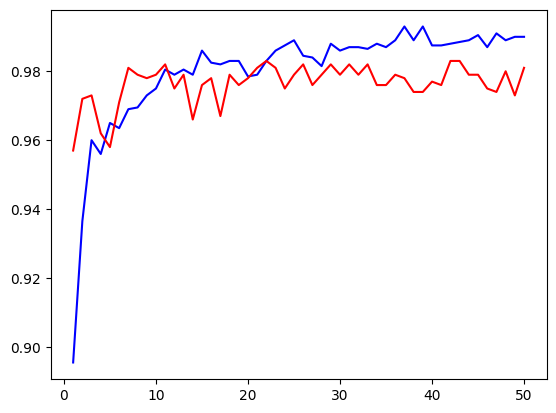

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.show()

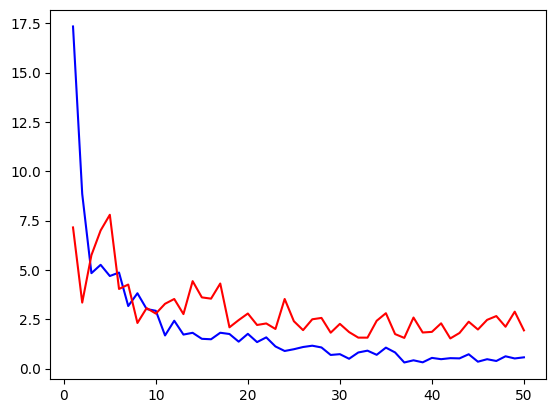

In [19]:
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.show()

In [20]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation_vgg16.x")
test_loss, test_accuracy = test_model.evaluate(test_dataset)

print(f"Accuracy: {test_accuracy}, Loss: {test_loss}")

32/32 [==============================] - 37s 1s/step - loss: 2.6762 - accuracy: 0.9770
Accuracy: 0.9769999980926514, Loss: 2.6762278079986572
